In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# *******************************  LOADING DATA  ***********************************


columnNames = ['seq_name','tag_id', 'timestamp', 'time', 'x_pos', 'y_pos', 'z_pos', 'activity']
df = pd.read_csv('/Users/viraoetterli/Downloads/ConfLongDemo_JSI.txt', sep=',', header=None, names=columnNames)

# Dropping unuseful columns
df = df.drop(columns=['timestamp', 'time'])

# Replacing values for clarity
df['tag_id'].replace({'010-000-024-033':'Ankle_left', '010-000-030-096':'Ankle_right',
                     '020-000-032-221':'Belt', '020-000-033-111':'Chest'}, inplace=True)

# Creating lists of unique values in class features
activities = df['activity'].unique()
sequences = df['seq_name'].unique()
sensors = df['tag_id'].unique()

display(df)

seq_name       tag_id     x_pos     y_pos     z_pos activity
0           A01   Ankle_left  4.062931  1.892434  0.507425  walking
1           A01        Chest  4.291954  1.781140  1.344495  walking
2           A01         Belt  4.359101  1.826456  0.968821  walking
3           A01   Ankle_left  4.087835  1.879999  0.466983  walking
4           A01  Ankle_right  4.324462  2.072460  0.488065  walking
...         ...          ...       ...       ...       ...      ...
164855      E05  Ankle_right  3.209474  2.044571  0.062902  walking
164856      E05   Ankle_left  3.386878  2.004729  0.395161  walking
164857      E05        Chest  3.188895  1.915717  1.353087  walking
164858      E05  Ankle_right  3.150169  1.931164  0.055037  walking
164859      E05   Ankle_left  3.209994  1.939577  0.364777  walking

[164860 rows x 6 columns]

In [112]:
# Creating dictionaries of dataframes

# Group the data by tag_identificator
grouped_sensors = df.groupby('tag_id')

# Dict for separated sensor dataframes
sensor_dfs = {}

# Dict for separated sensor dataframes
sensor_seq_dfs = {}

# Loop through each group and create new dataframes
for sensor, group in grouped_sensors:
    sensor_df = pd.DataFrame(group)
    
    # Add each sensor dataframe to dictionary
    sensor_dfs[sensor] = sensor_df
    
    # Group the sensors by sequence name
    grouped_sequences = sensor_df.groupby('seq_name')
    
    # Loop through each sensor-sequence group and create new dataframes
    for sequence, group in grouped_sequences:
        
        sequence_df = pd.DataFrame(group)
        
        name = sequence + " " + sensor
        
        # Add each sensor-sequence dataframe to dictionary
        sensor_seq_dfs[name] = sequence_df

In [294]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import seaborn as sns

# Importing notebook makes rotating plots possible
%matplotlib notebook

from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D



# *******************************  OUTLIER DETECTION  ***********************************



smooth_dfs = {}
smooth_midpoints = {}

def plot_outliers_2D(outlier_df, smooth_df, key):
    # Plot the outliers per sensor in 2D, with x,y-coordinates as axis
    ax = plt.figure().add_subplot()
    
    # Outlier data
    ax.scatter(outlier_df['x_pos'], outlier_df['y_pos'], c="r")
    
    # Data without outliers
    ax.scatter(smooth_df['x_pos'], smooth_df['y_pos'])
    
    ax.set_xlabel('X-coordinate') ; ax.set_ylabel('Y-coordinate')
    ax.set_xlim(0,6) ; ax.set_ylim(0,4)
    ax.set_title(key)
    plt.show()

def plot_outliers_3D(outlier_df, smooth_df, key):
    # Plot the outliers per sensor in 3D, with x,y,z-coordinates as axis
    ax = plt.figure().add_subplot(111, projection='3d')
    
    # Outlier data
    ax.scatter(outlier_df['x_pos'], outlier_df['y_pos'], outlier_df['z_pos'], c="r")
    
    # Data without outliers
    ax.scatter(smooth_df['x_pos'], smooth_df['y_pos'], smooth_df['z_pos'])
    
    ax.set_xlabel('X-coordinate') ; ax.set_ylabel('Y-coordinate') ; ax.set_zlabel('Z-coordinate')
    ax.set_xlim(0,6) ; ax.set_ylim(0,4) ; ax.set_zlim(-2,3)
    ax.set_title(key)
    plt.show()

def plot_outliers_class_2D(outlier_df, smooth_df, key):
    # Plot activities in 2D with x,y-cooridnates
    
    ax = plt.figure().add_subplot()
    for i, activity in enumerate(activities):
        smooth_act_df = smooth_df[smooth_df['activity'] == activity]
        outlier_act_df = outlier_df[outlier_df['activity'] == activity]
        
        # Plot per sensor and activity
        ax.scatter(smooth_act_df['x_pos'], smooth_act_df['y_pos'])
        #ax.scatter(outlier_act_df['x_pos'], outlier_act_df['y_pos'])
        ax.set_xlabel('X-coordinate') ; ax.set_ylabel('Y-coordinate')
        ax.set_xlim(0,6) ; ax.set_ylim(0,4)
        ax.set_title(key)
    ax.legend(activities, fontsize=6)
    plt.show()

def plot_outliers_class_3D(outlier_df, smooth_df, key):
    # Plot activities in 3D with x,y,z-cooridnates
    ax = plt.figure().add_subplot(111, projection='3d')
    for activity in activities:
        smooth_act_df = smooth_df[smooth_df['activity'] == activity]
        outlier_act_df = outlier_df[outlier_df['activity'] == activity]
        
        # Plot per sensor and activity
        ax.scatter(smooth_act_df['x_pos'], smooth_act_df['y_pos'], smooth_act_df['z_pos'])
        #ax.scatter(outlier_act_df['x_pos'], outlier_act_df['y_pos'], outlier_act_df['z_pos'])
        ax.set_xlabel('X-coordinate') ; ax.set_ylabel('Y-coordinate') ; ax.set_zlabel('Z-coordinate')
        ax.set_xlim(0,6) ; ax.set_ylim(0,4) ; ax.set_zlim(-2,3)
        title = key
        ax.set_title(key)
    ax.legend(activities, fontsize=6)
    plt.show()

def outlier_detection(key, data):
    # Function which predicts the outliers using isolation forest
    
    # Drop columns we shouldn't use in prediction
    new_df = data.drop(columns=["seq_name", "tag_id", "activity"])
    
    # Fit the Isolation Forest algorithm to the data
    isolation_forest = IsolationForest(n_estimators=50, contamination=0.1, random_state=42)
    isolation_forest.fit(new_df)

    # Predict the anomalies in the data
    outlier_scores = isolation_forest.decision_function(new_df)
    outlier_predictions = isolation_forest.predict(new_df)
    
    # Add the outlier scores and predictions to the original dataframe
    data["outlier_score"] = outlier_scores
    data["outlier_prediction"] = outlier_predictions
    
    # A new dataframe with only the outliers in the rows
    outlier_df = data[data["outlier_prediction"] == -1]
    
    # Dataframe with only the "normal" datapoints appended to dictionary
    smooth_df = data[data["outlier_prediction"] == 1]
    
    filename = key + '.csv'
    smooth_df.to_csv(filename)
    
    smooth_dfs[key] = smooth_df
    
    #plot_outliers_2D(outlier_df, smooth_df, key)
    #plot_outliers_3D(outlier_df, smooth_df, key)
    
    #plot_outliers_class_2D(outlier_df, smooth_df, key)
    #plot_outliers_class_3D(outlier_df, smooth_df, key)

# Iterating through the dataframes for each SENSOR
for key, data in sensor_dfs.items():
    outlier_detection(key, data)

# Iterating through the dataframes for each SENSOR and each SEQUENCE
'''for key, data in sensor_seq_dfs.items():
    outlier_detection(key, data)'''

# Tests
#outlier_detection('Chest', sensor_dfs['Chest'])
#outlier_detection('Ankle_left', sensor_dfs['Ankle_left'])

#outlier_detection('A01 Chest', sensor_seq_dfs['A01 Chest'])

'''test_dict = {'A01 Chest': sensor_seq_dfs['A01 Chest'], 'B04 Chest': sensor_seq_dfs['B04 Chest']}
for key, value in test_dict.items():
    outlier_detection(key, value)'''

"test_dict = {'A01 Chest': sensor_seq_dfs['A01 Chest'], 'B04 Chest': sensor_seq_dfs['B04 Chest']}\nfor key, value in test_dict.items():\n    outlier_detection(key, value)"

<IPython.core.display.Javascript object>


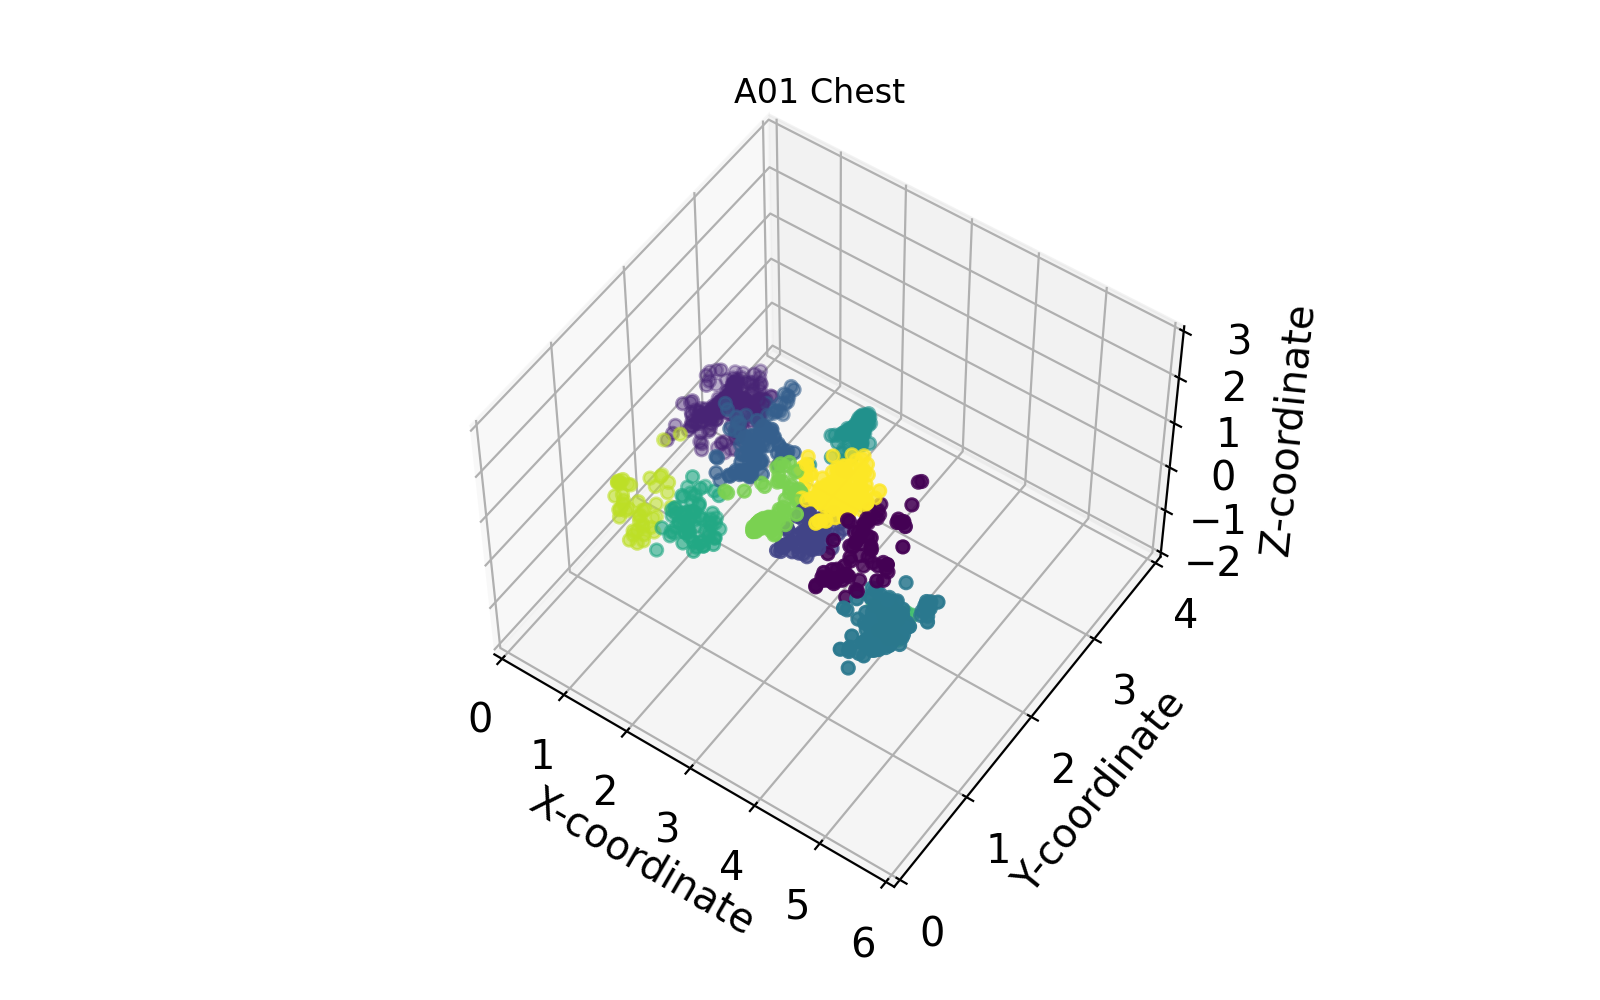

In [277]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # (look more into this)



# *******************************  K-MEANS CLUSTERING  ***********************************



def kmeans(key, smooth_df):
    # Drop unnecessary columns
    clean_df = smooth_df.drop(columns=["seq_name","tag_id","activity","outlier_prediction","outlier_score"])

    # Set the number of clusters
    k = len(activities)

    # Run K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=1)
    y = kmeans.fit_predict(clean_df)
    
    # Plot the results in 3D
    ax = plt.figure().add_subplot(111, projection='3d')
    ax.scatter(clean_df.iloc[:, 0], clean_df.iloc[:, 1], clean_df.iloc[:, 2], c=y)
    ax.set_xlabel('X-coordinate'); ax.set_ylabel('Y-coordinate'); ax.set_zlabel('Z-coordinate')
    ax.set_xlim(0,6); ax.set_ylim(0,4); ax.set_zlim(-2,3); ax.set_title(key)
    plt.show()
    
    '''# Plot the results in 2D (X- and Y-coordinate)
    ax = plt.figure().add_subplot()
    ax.scatter(clean_df.iloc[:, 0], clean_df.iloc[:, 1], c=y)
    plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],
       s=50,c='black',marker='x')
    ax.set_xlabel('X-coordinate'); ax.set_ylabel('Y-coordinate'); 
    #ax.set_xlim(0,6); ax.set_ylim(0,4); 
    ax.set_title(key)
    plt.show()'''

for key, smooth_df in smooth_dfs.items():
    kmeans(key, smooth_df)

In [115]:

# *******************************  FAILED ATTEMPT AT K-MEDOIDS  ***********************************


'''def kmedoids(key, tag):
    from sklearn_extra.cluster import KMedoids
    from sklearn.preprocessing import StandardScaler
    
    
    # Normalize the data
    scaler = StandardScaler()
    normalized_df = scaler.fit_transform(tag)

    # Perform k-medoids clustering
    k = 5
    kmedoids = KMedoids(n_clusters=k, random_state=42)
    y = kmedoids.fit_predict(tag)

    # Plot the results in 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(tag[:, 0], tag[:, 1], tag[:, 2], c=y, cmap='viridis')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

for key, tag_df in tags.items():
    cleaned_tag_df = tag_df.drop(columns=["sequence_name", "tag_identificator", "date_format", "timestamp", "second", "anomaly_prediction","activity", "anomaly_score"])
    kmedoids(key, cleaned_tag_df)'''

'''cleaned_tag_df = tags['020-000-033-111'].drop(columns=["sequence_name", "tag_identificator", "date_format", "timestamp", "second", "anomaly_prediction","activity", "anomaly_score"])
kmedoids('020-000-033-111', cleaned_tag_df)'''

'cleaned_tag_df = tags[\'020-000-033-111\'].drop(columns=["sequence_name", "tag_identificator", "date_format", "timestamp", "second", "anomaly_prediction","activity", "anomaly_score"])\nkmedoids(\'020-000-033-111\', cleaned_tag_df)'

<IPython.core.display.Javascript object>


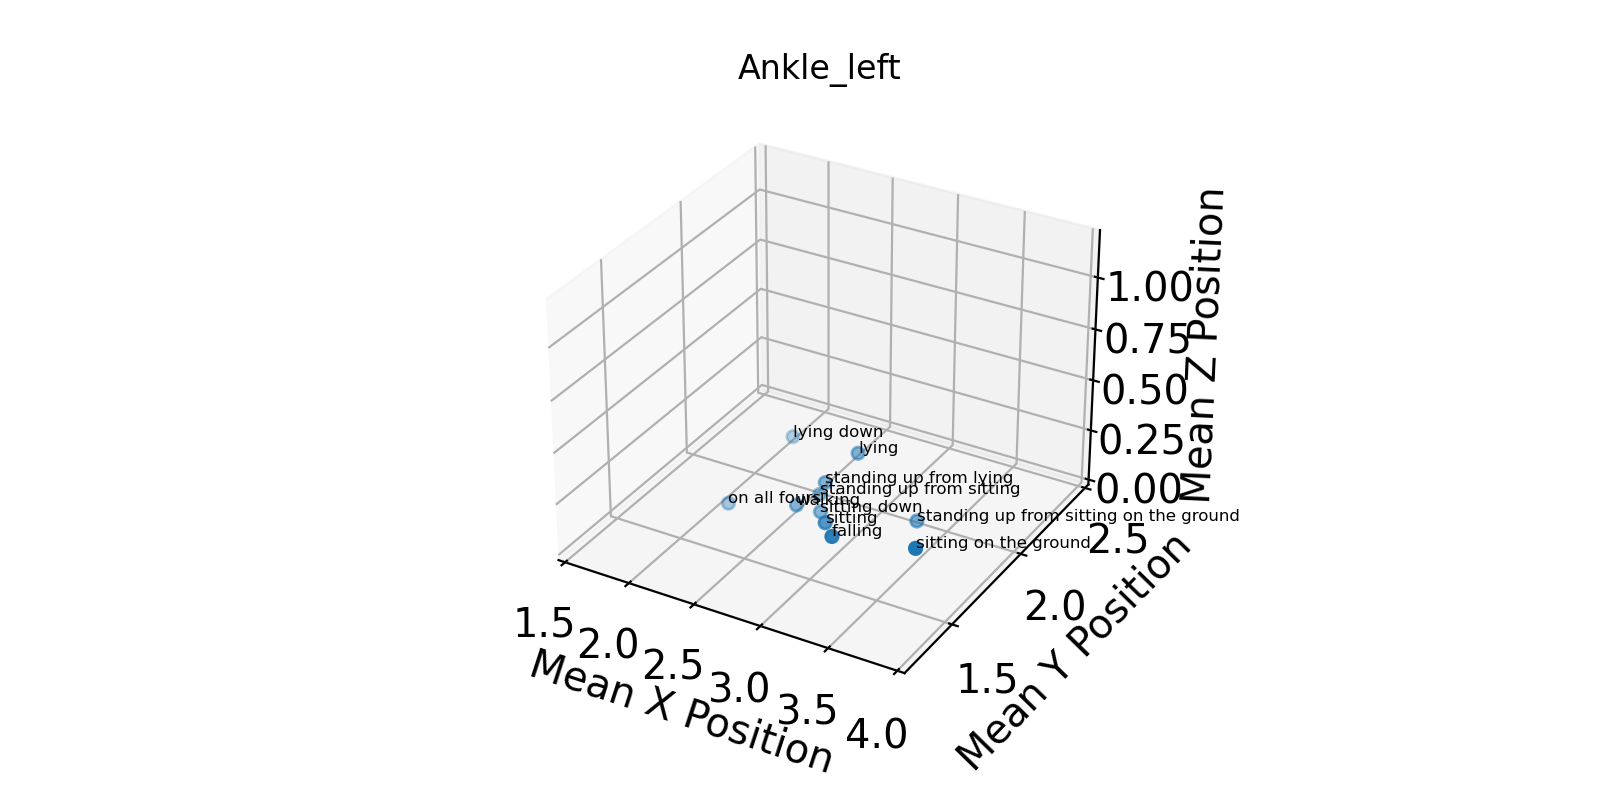

<IPython.core.display.Javascript object>


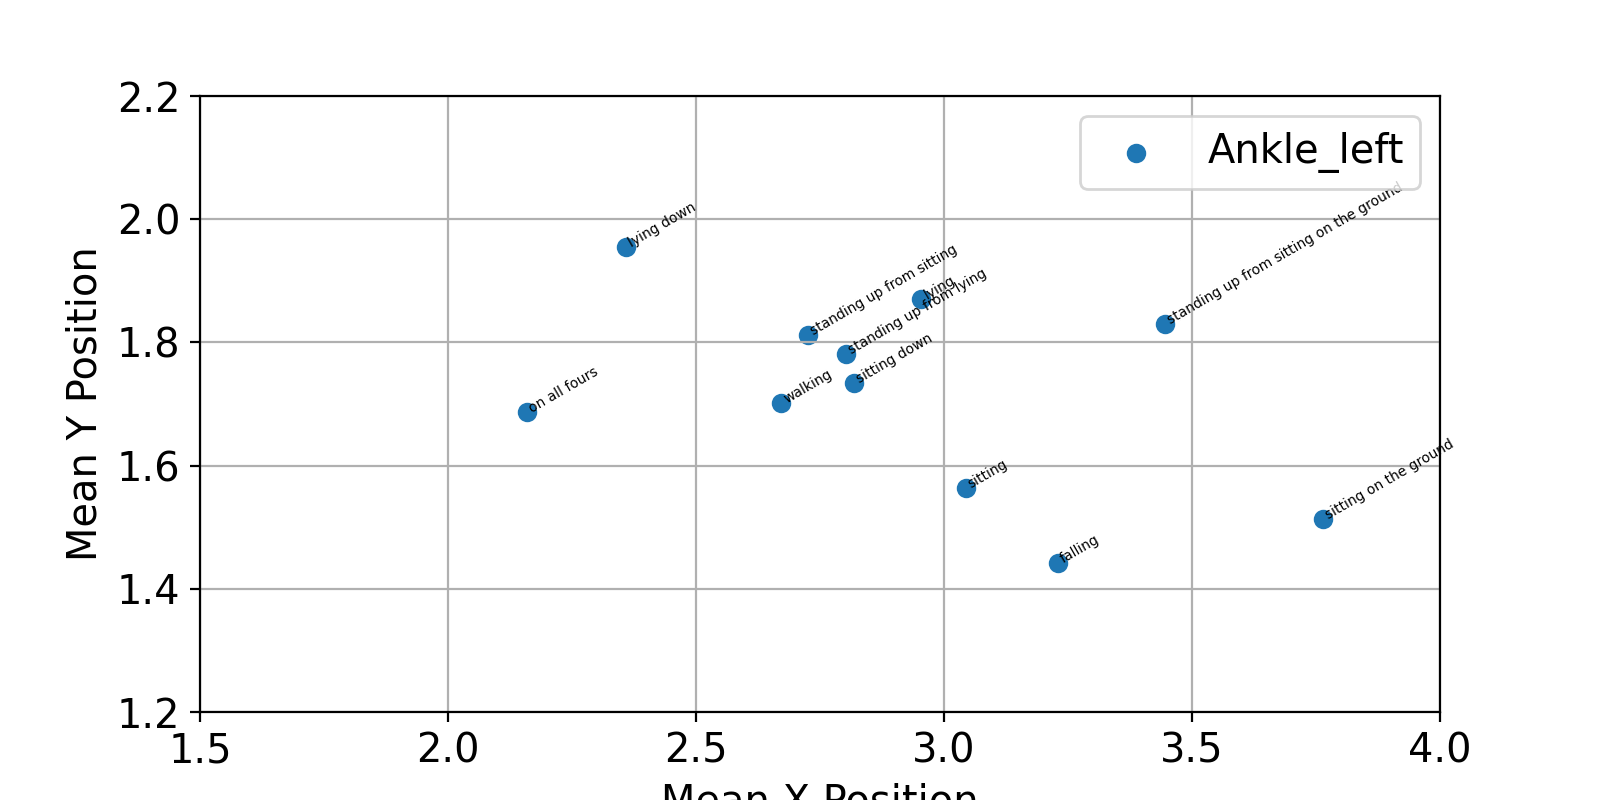

<IPython.core.display.Javascript object>


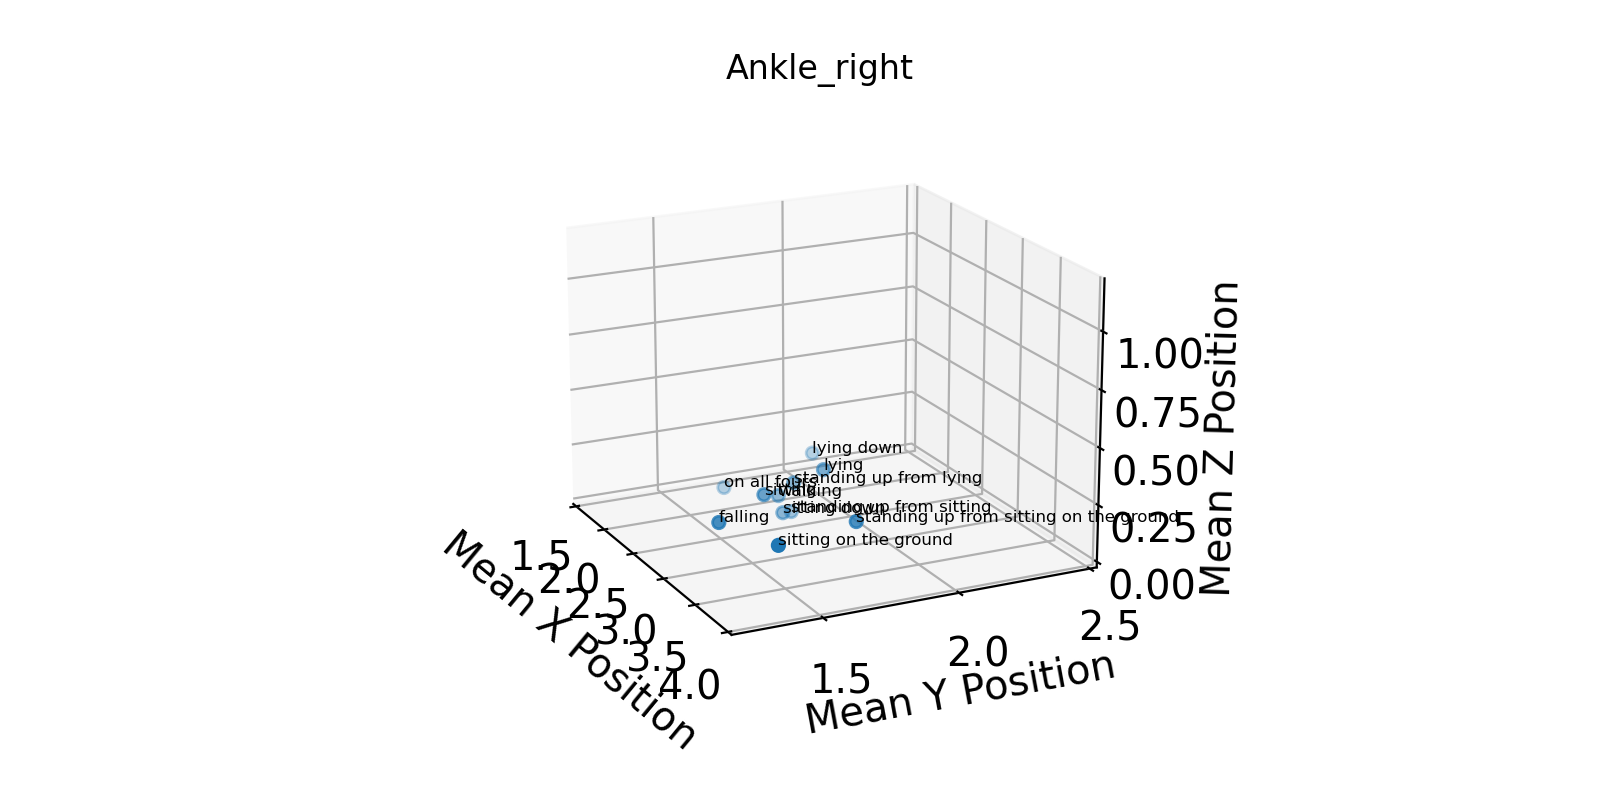

<IPython.core.display.Javascript object>


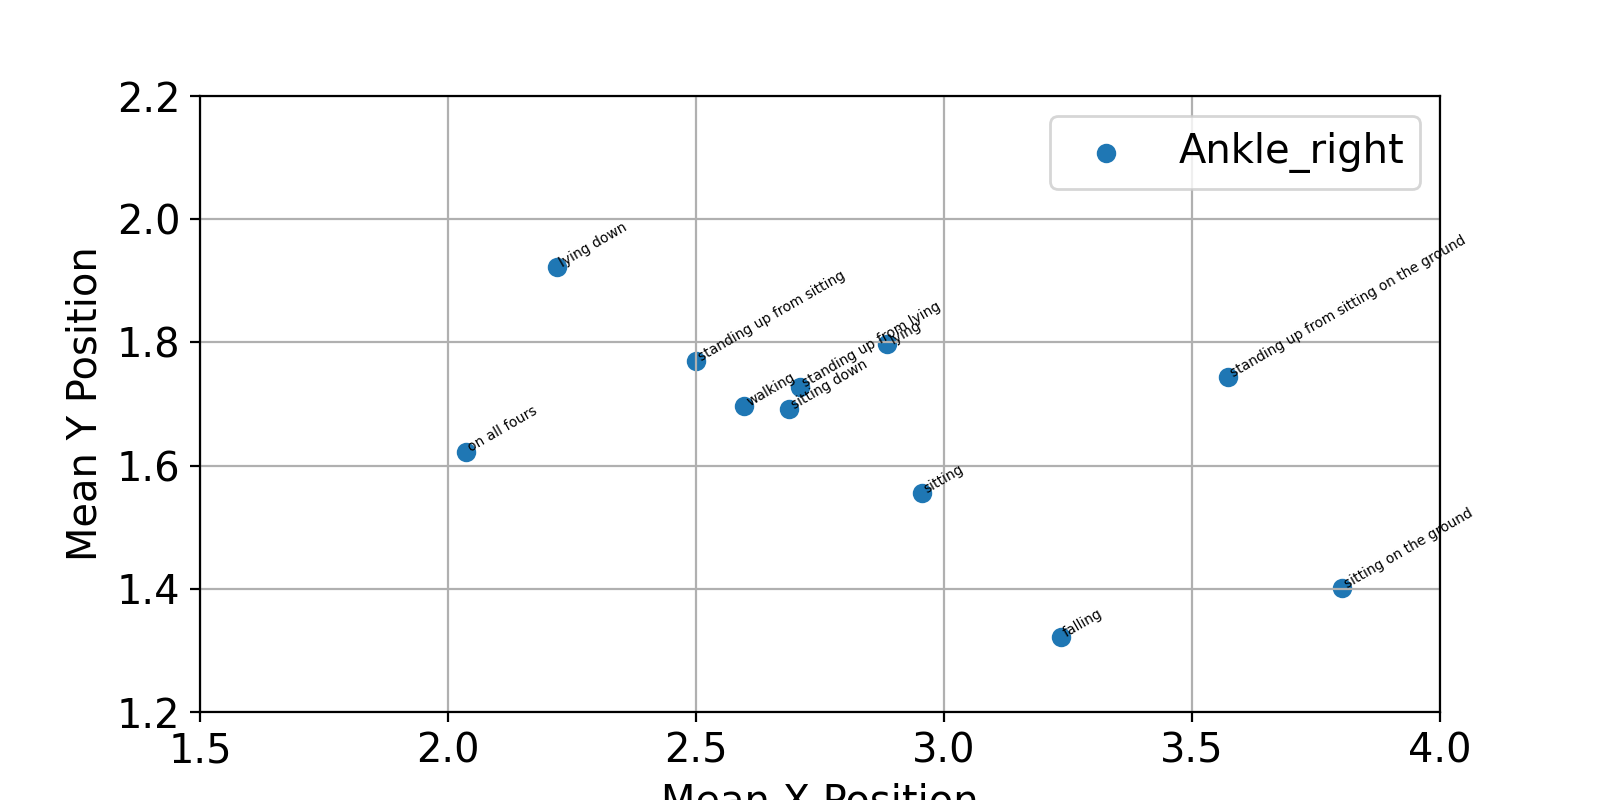

<IPython.core.display.Javascript object>


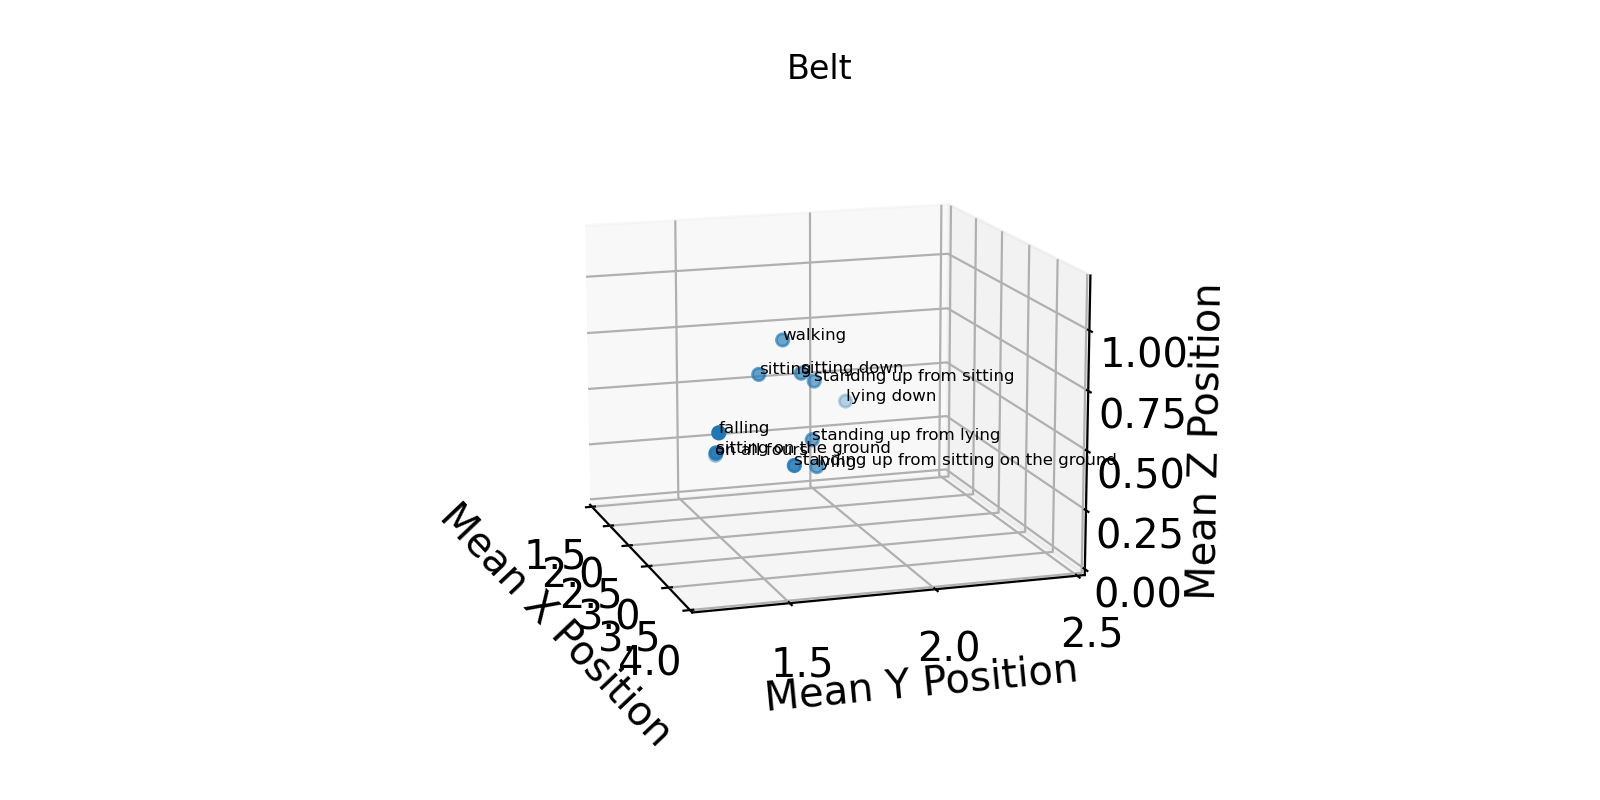

<IPython.core.display.Javascript object>


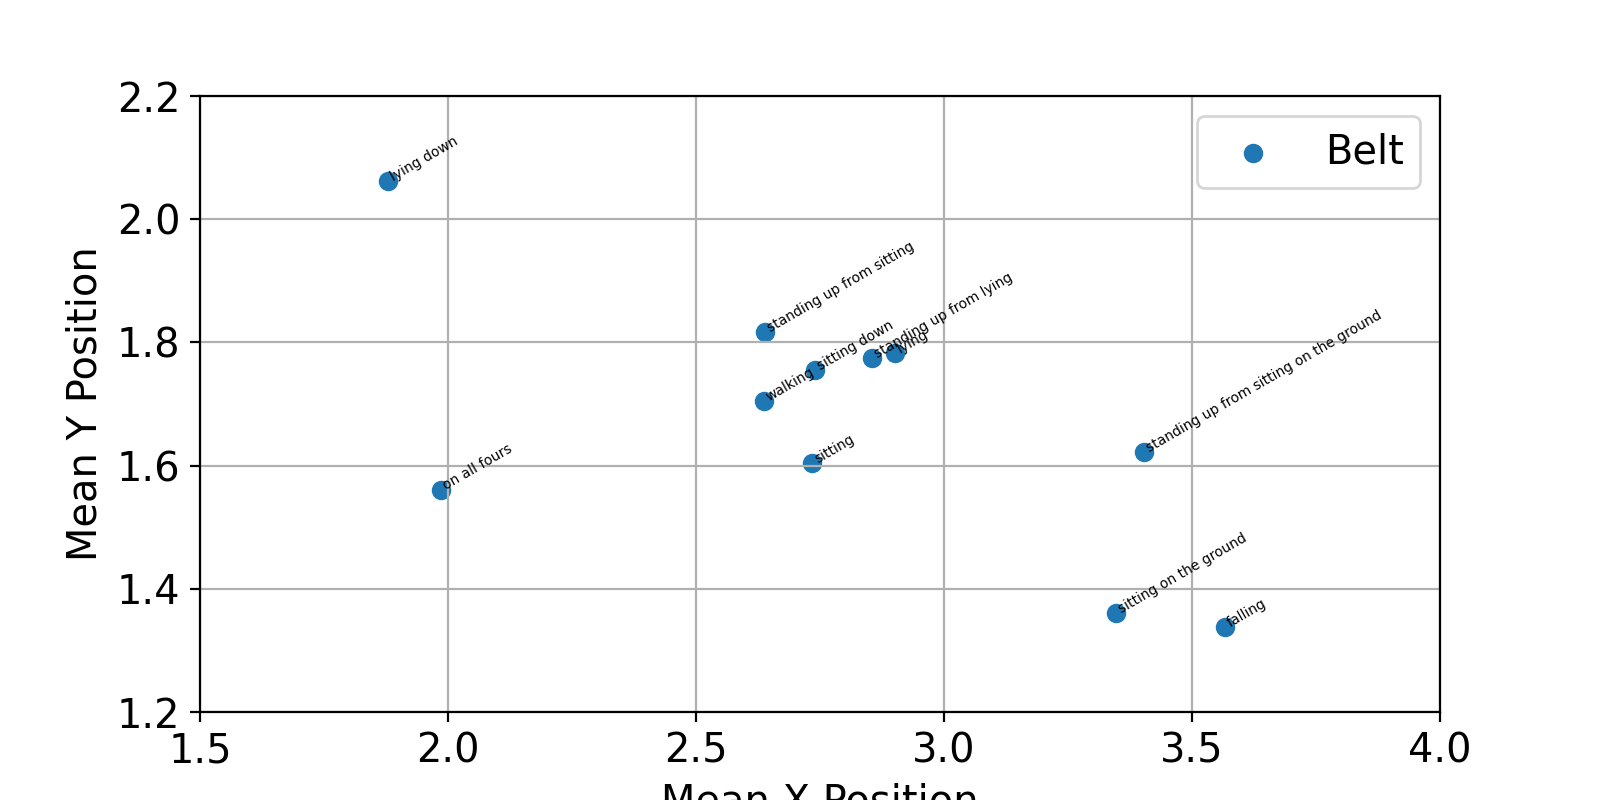

<IPython.core.display.Javascript object>


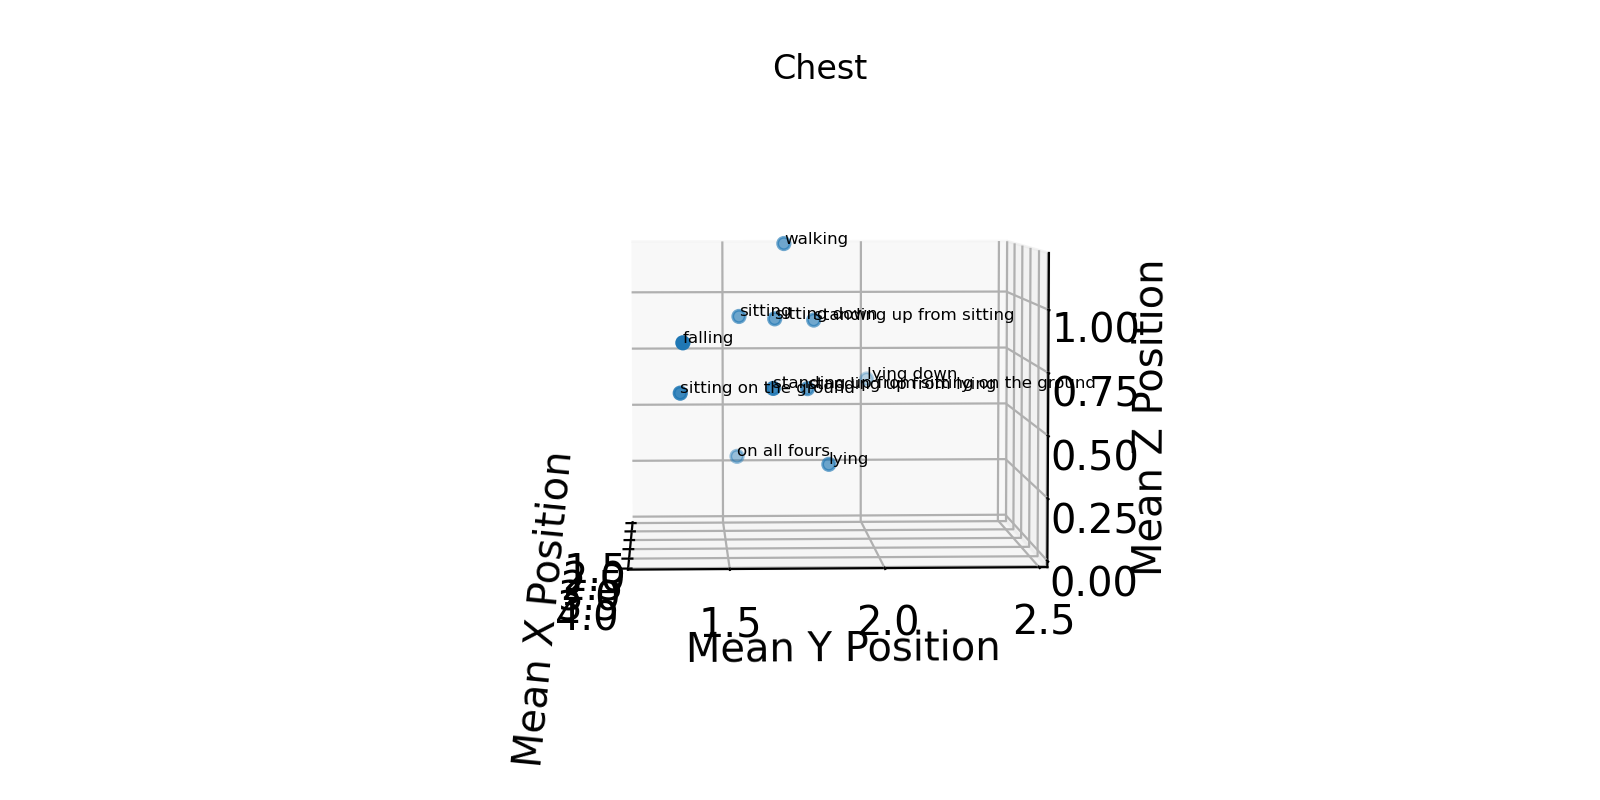

<IPython.core.display.Javascript object>


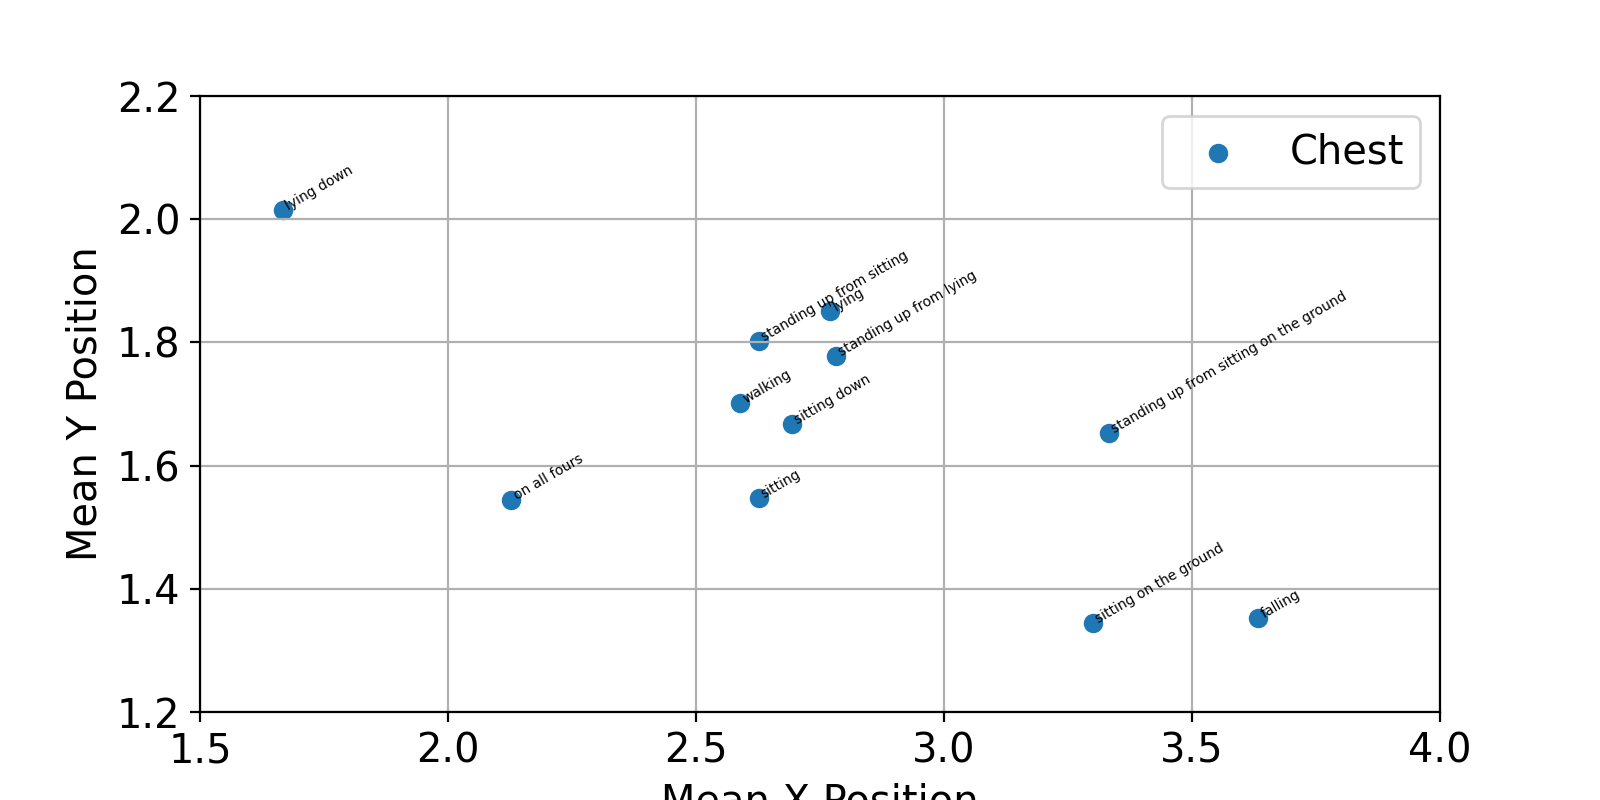

In [292]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# Importing notebook makes rotating plots possible
%matplotlib notebook

mean_sensor_dfs = {}


# *******************************  PLOTTING THE MIDPOINTS WITHOUT OUTLIERS PER SENSOR ***********************************

# *******************************  ALL SEQUENCES AND ALL ACTIVITIES ARE INCLUDED ***********************************


# Iterating through the cleaned up dataframes for each sensor
for key, smooth_df in smooth_dfs.items():
    
    # Empty dataframe with the columns we are going to append to
    mean_df = pd.DataFrame(columns=['activity', 'mean_x_pos', 'mean_y_pos', 'mean_z_pos'])
    
    # Group the activites
    groups = smooth_df.groupby('activity')
    
    # Loop through each activity
    for activity, dataframe in groups:
        # Calculate the mean value for the x_pos and y_pos
        mean_x_pos = dataframe['x_pos'].mean()
        mean_y_pos = dataframe['y_pos'].mean()
        mean_z_pos = dataframe['z_pos'].mean()
        
        # Create a new row for the mean values and activity
        new_row = {'activity': activity, 'mean_x_pos': mean_x_pos, 'mean_y_pos': mean_y_pos, 'mean_z_pos': mean_z_pos}
        
        # Append the new row to the mean_df
        mean_df = mean_df.append(new_row, ignore_index=True)

    mean_sensor_dfs[key] = mean_df


for sensor, mean_df in mean_sensor_dfs.items():
    # plot the mean positions in 3D
    ax = plt.figure().add_subplot(111, projection='3d')
    ax.scatter(mean_df['mean_x_pos'], mean_df['mean_y_pos'], mean_df['mean_z_pos'], label=sensor)
    
    # add text labels for each point
    for i, txt in enumerate(mean_df['activity']):
        ax.text(mean_df['mean_x_pos'][i], mean_df['mean_y_pos'][i], mean_df['mean_z_pos'][i], txt, 
                fontsize=6, rotation=30)

    ax.set_xlabel('Mean X Position'); ax.set_ylabel('Mean Y Position'); ax.set_zlabel('Mean Z Position')
    ax.set_xlim(1.5,4); ax.set_ylim(1.2,2.5); ax.set_zlim(0,1.2)
    
    ax.set_title(sensor)
    plt.show()
    
    # plot the mean positions in 2D
    ax = plt.figure().add_subplot()
    ax.scatter(mean_df['mean_x_pos'], mean_df['mean_y_pos'], label=sensor)

    # add text labels for each point
    for i, txt in enumerate(mean_df['activity']):
        ax.text(mean_df['mean_x_pos'][i], mean_df['mean_y_pos'][i], txt, fontsize=5, rotation=30)

    ax.set_xlabel('Mean X Position'); ax.set_ylabel('Mean Y Position'); ax.legend()
    ax.set_xlim(1.5,4); ax.set_ylim(1.2,2.2)
    plt.grid(); plt.show()

In [117]:
# ********************************************************************************************************
# *******************************  HERE WE START WITH THE NEW DATASET  ***********************************
# ********************************************************************************************************

In [118]:
# Loading the new dataframe witht the grouped coordinates
grouped_df = pd.read_csv('/Users/viraoetterli/Downloads/merged_data_NEWer.csv', sep=',')
grouped_df = grouped_df.drop(columns=['timestamp', 'date'])

# Replacing values for clarity
grouped_df.rename(columns = {'chest_x-coordinate':'x_chest','chest_y-coordinate':'y_chest',
                              'chest_z-coordinate':'z_chest','belt_x-coordinate':'x_belt',
                             'belt_y-coordinate':'y_belt','belt_z-coordinate':'z_belt',
                            'ar_x-coordinate':'x_ar','ar_y-coordinate':'y_ar',
                             'ar_z-coordinate':'z_ar','al_x-coordinate':'x_al',
                             'al_y-coordinate':'y_al','al_z-coordinate':'z_al'}, inplace = True)

display(grouped_df)

sequence_name activity   x_chest   y_chest   z_chest    x_belt  \
0                A01  walking  4.291954  1.781140  1.344495  4.359101   
1                A01  walking  4.291954  1.781140  1.344495  4.359101   
2                A01  walking  4.309984  1.777778  1.333371  4.359101   
3                A01  walking  4.328015  1.774416  1.322246  4.362803   
4                A01  walking  4.346046  1.771054  1.311121  4.366505   
...              ...      ...       ...       ...       ...       ...   
164855           E05  walking  3.140489  1.936017  1.423725  3.359577   
164856           E05  walking  3.164692  1.925867  1.388406  3.359577   
164857           E05  walking  3.188895  1.915717  1.353087  3.359577   
164858           E05  walking  3.188895  1.915717  1.353087  3.359577   
164859           E05  walking  3.188895  1.915717  1.353087  3.359577   

          y_belt    z_belt      x_ar      y_ar      z_ar      x_al      y_al  \
0       1.826456  0.968821  4.324462  2.072460  0.488065  4.062931  1.892434   
1       1.826456  0.968821  4.324462  2.072460  0.488065  4.071232  1.888289   
2       1.826456  0.968821  4.324462  2.072460  0.488065  4.079534  1.884144   
3       1.841832  0.918870  4.324462  2.072460  0.488065  4.087835  1.879999   
4       1.857208  0.868920  4.324462  2.072460  0.488065  4.055501  1.835890   
...          ...       ...       ...       ...       ...       ...       ...   
164855  2.027247  1.070798  3.209474  2.044571  0.062902  3.351634  1.988035   
164856  2.027247  1.070798  3.189705  2.006769  0.060280  3.386878  2.004729   
164857  2.027247  1.070798  3.169937  1.968966  0.057659  3.327917  1.983011   
164858  2.027247  1.070798  3.150169  1.931164  0.055037  3.268955  1.961294   
164859  2.027247  1.070798  3.150169  1.931164  0.055037  3.209994  1.939577   

            z_al  
0       0.507425  
1       0.493945  
2       0.480464  
3       0.466983  
4       0.477998  
...          ...  
164855  0.393693  
164856  0.395161  
164857  0.385033  
164858  0.374905  
164859  0.364777  

[164860 rows x 14 columns]

In [119]:

# *******************************  CORRELATION MATRIX  ***********************************


corr = grouped_df.corr()  # getting the correlation matrix for the coordinates
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2) # plotting the correlation matrix

In [120]:
# Creating dictionaries of dataframes

# Group the data by sequence_name
group_sequences = grouped_df.groupby("sequence_name")

# Dict for separated sequence dataframes
seq_dfs = {}

# Loop through each group and create new dataframes
for sequence, dataframe in group_sequences:
    # Add each sensor dataframe to dictionary
    seq_dfs[sequence] = pd.DataFrame(dataframe)

In [284]:
smooth_group_dfs = {}

smooth_all_df = []

# *******************************  OUTLIER DETECTION  ***********************************


def outlier_detection(key, data):
    # Function which predicts the outliers using isolation forest

    # Drop columns we shouldn't use in prediction
    new_df = data.drop(columns=["sequence_name", "activity"])
    
    # Fit the Isolation Forest algorithm to the data
    isolation_forest = IsolationForest(n_estimators=50, contamination=0.1, random_state=42)
    isolation_forest.fit(new_df)

    # Predict the anomalies in the data
    outlier_scores = isolation_forest.decision_function(new_df)
    outlier_predictions = isolation_forest.predict(new_df)
    
    # Add the outlier scores and predictions to the original dataframe
    data["outlier_score"] = outlier_scores
    data["outlier_prediction"] = outlier_predictions
    
    # Dataframe with only the "normal" datapoints
    smooth_group_df = data[data["outlier_prediction"] == 1]
    smooth_group_df = smooth_group_df.drop(columns=["outlier_prediction","outlier_score","sequence_name"])
    if key == "All sequences":
        smooth_all_df.append(smooth_group_df)
    else:
        smooth_group_dfs[key] = smooth_group_df

# Iterating through the dataframes for each sensor
for key, data in seq_dfs.items():
    outlier_detection(key, data)

outlier_detection("All sequences", grouped_df)

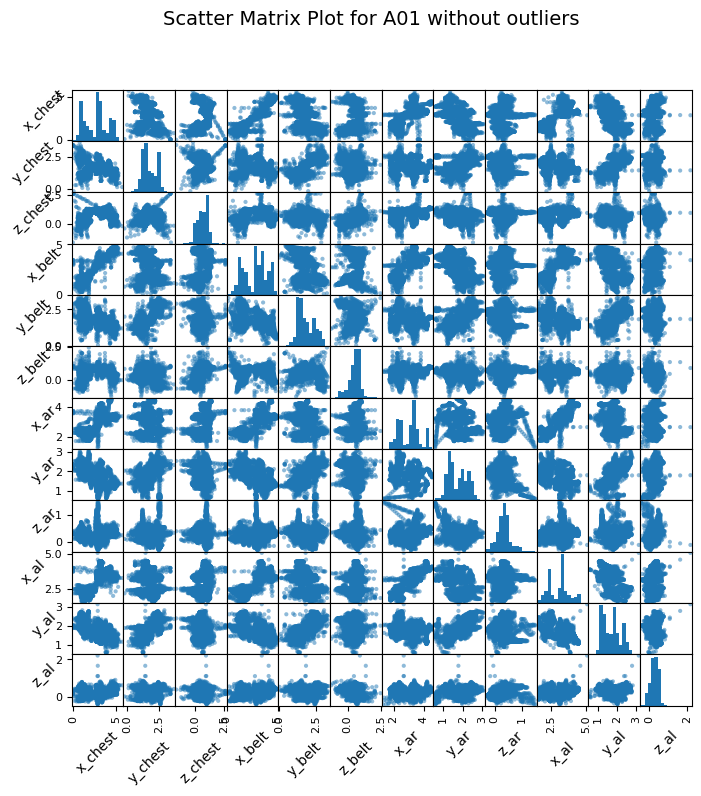

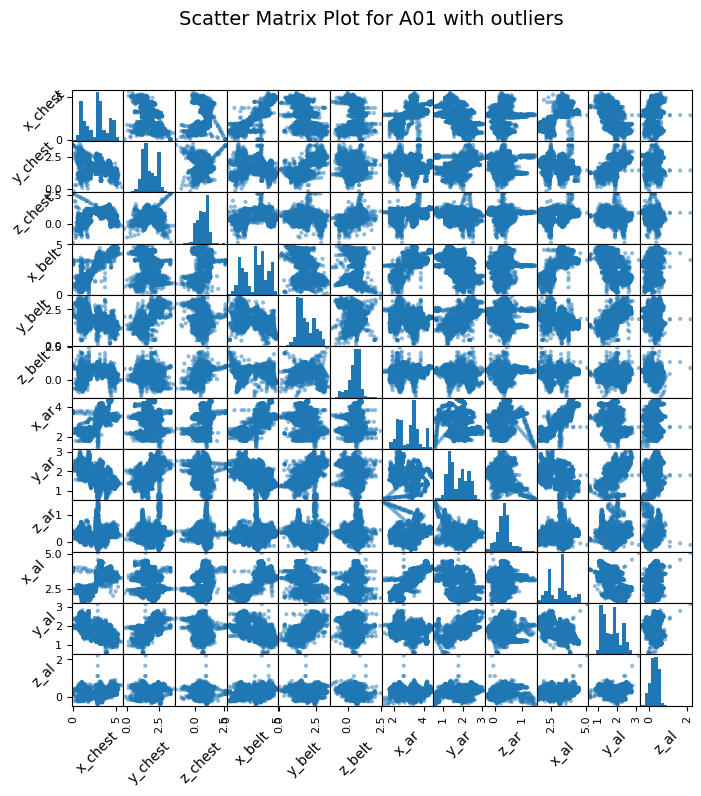

In [218]:


# *******************************  SCATTER MATRIX  ***********************************


def scatter_matrix(dataframe, title):
    params = {'legend.fontsize': 'x-large', 'figure.figsize': (8, 8),
          'axes.labelsize': 'medium', 'xtick.labelsize': 'medium',
          'ytick.labelsize': 'medium'}
    plt.rcParams.update(params)

    scatter_matrix = pd.plotting.scatter_matrix(dataframe,hist_kwds={'bins': 15},label=list(dataframe.keys()))
    for ax in scatter_matrix.flatten():
        ax.xaxis.label.set_rotation(45)
        ax.yaxis.label.set_rotation(45)
        
    plt.suptitle(title, fontsize=14)
    plt.show()

# Plotting scatter matrix for sequence A01 WITHOUT outliers, x,y,z-coordinates for all sensors
dataframe_smooth = smooth_group_dfs["A01"]
scatter_matrix(dataframe, "Scatter Matrix Plot for A01 without outliers")
    
# Plotting scatter matrix for sequence A01 WITH outliers, x,y,z-coordinates for all sensors
dataframe_outliers = seq_dfs["A01"].drop(columns=["outlier_score","outlier_prediction"])
scatter_matrix(dataframe, "Scatter Matrix Plot for A01 with outliers")

<IPython.core.display.Javascript object>


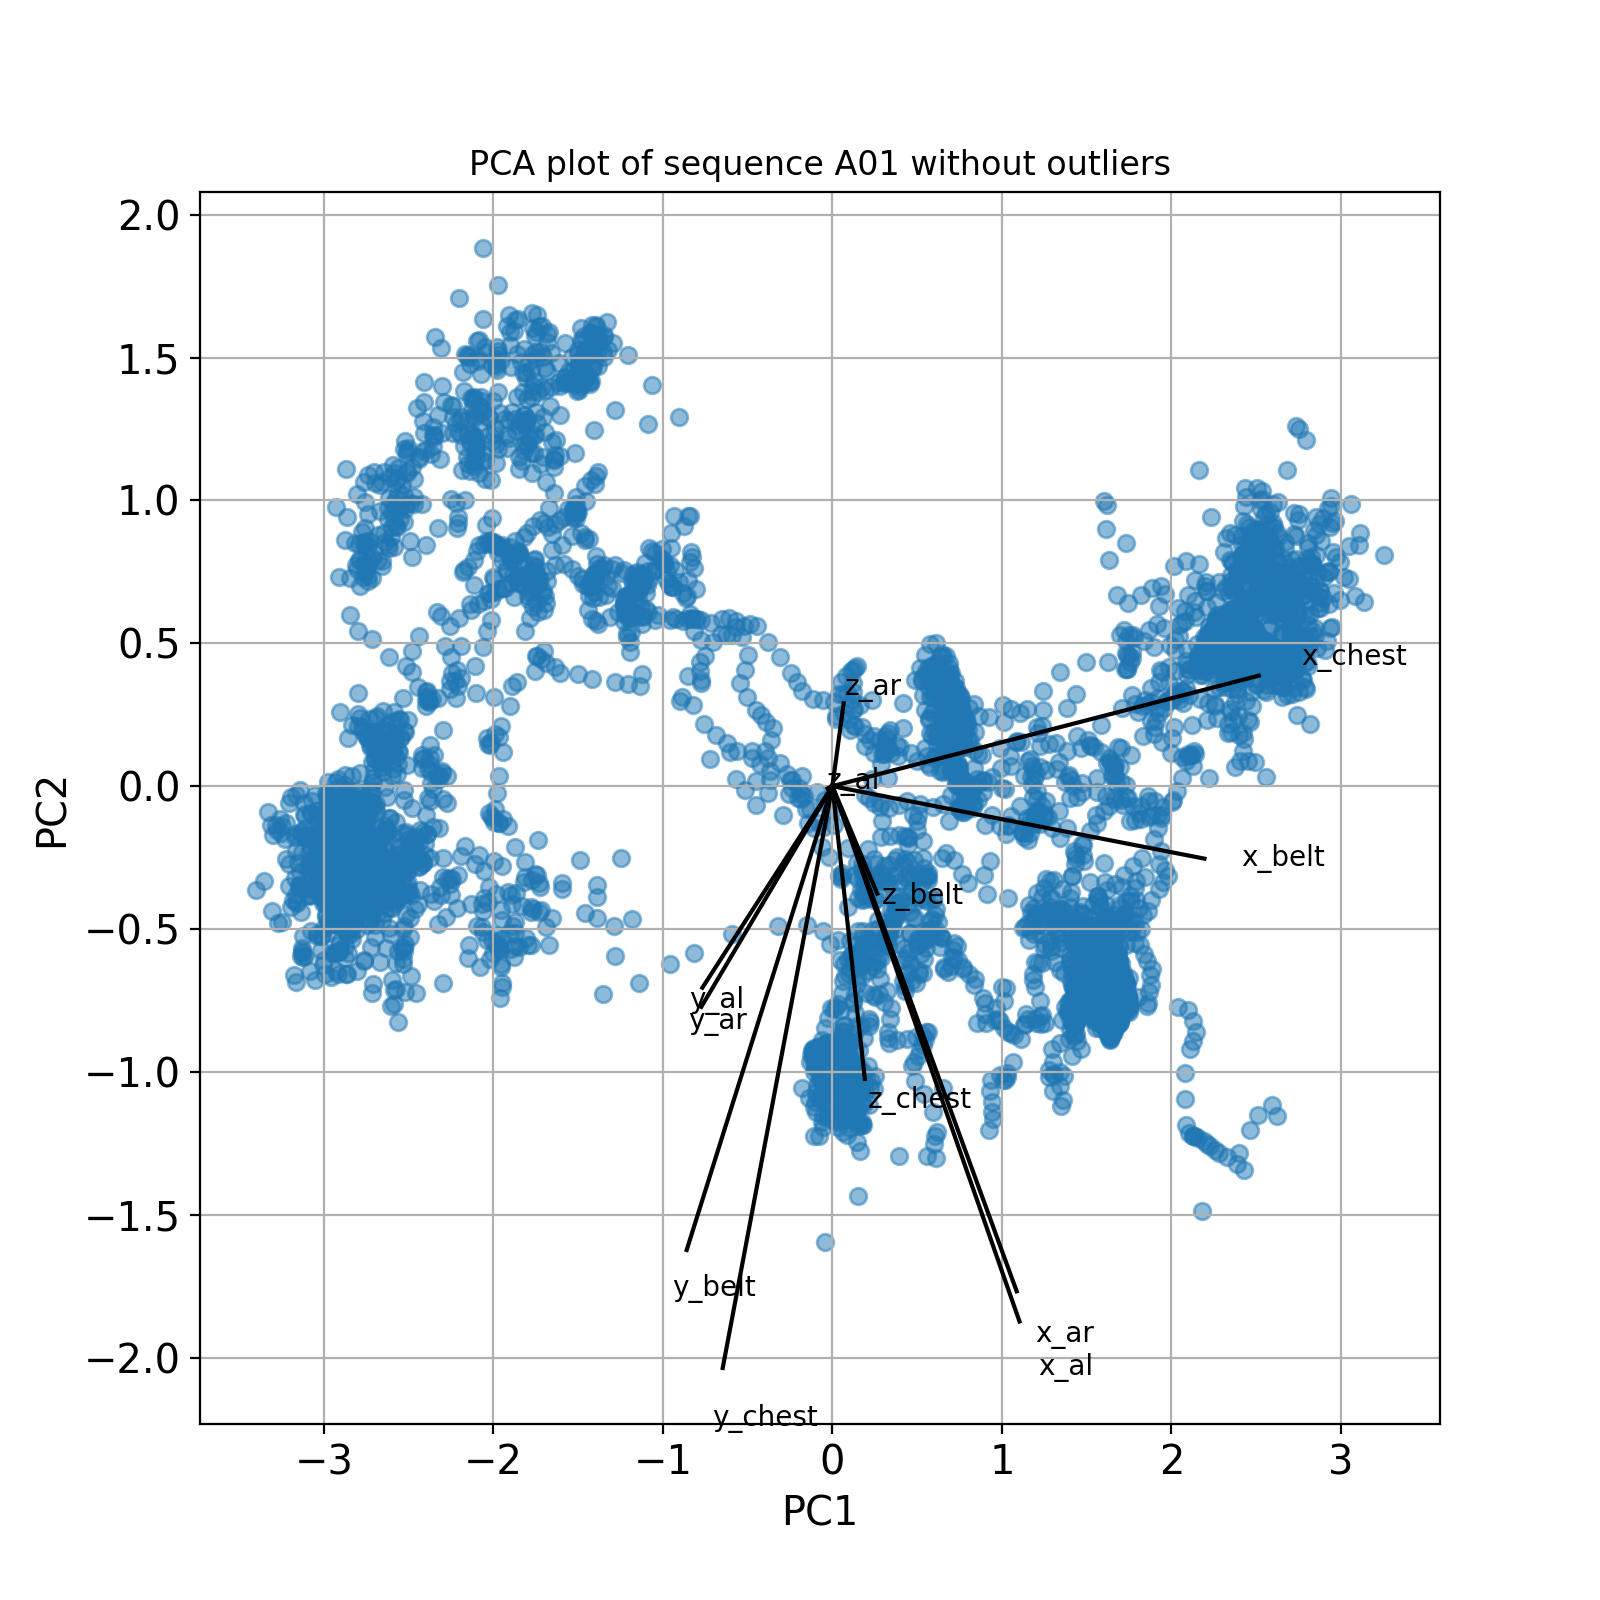

12


<IPython.core.display.Javascript object>


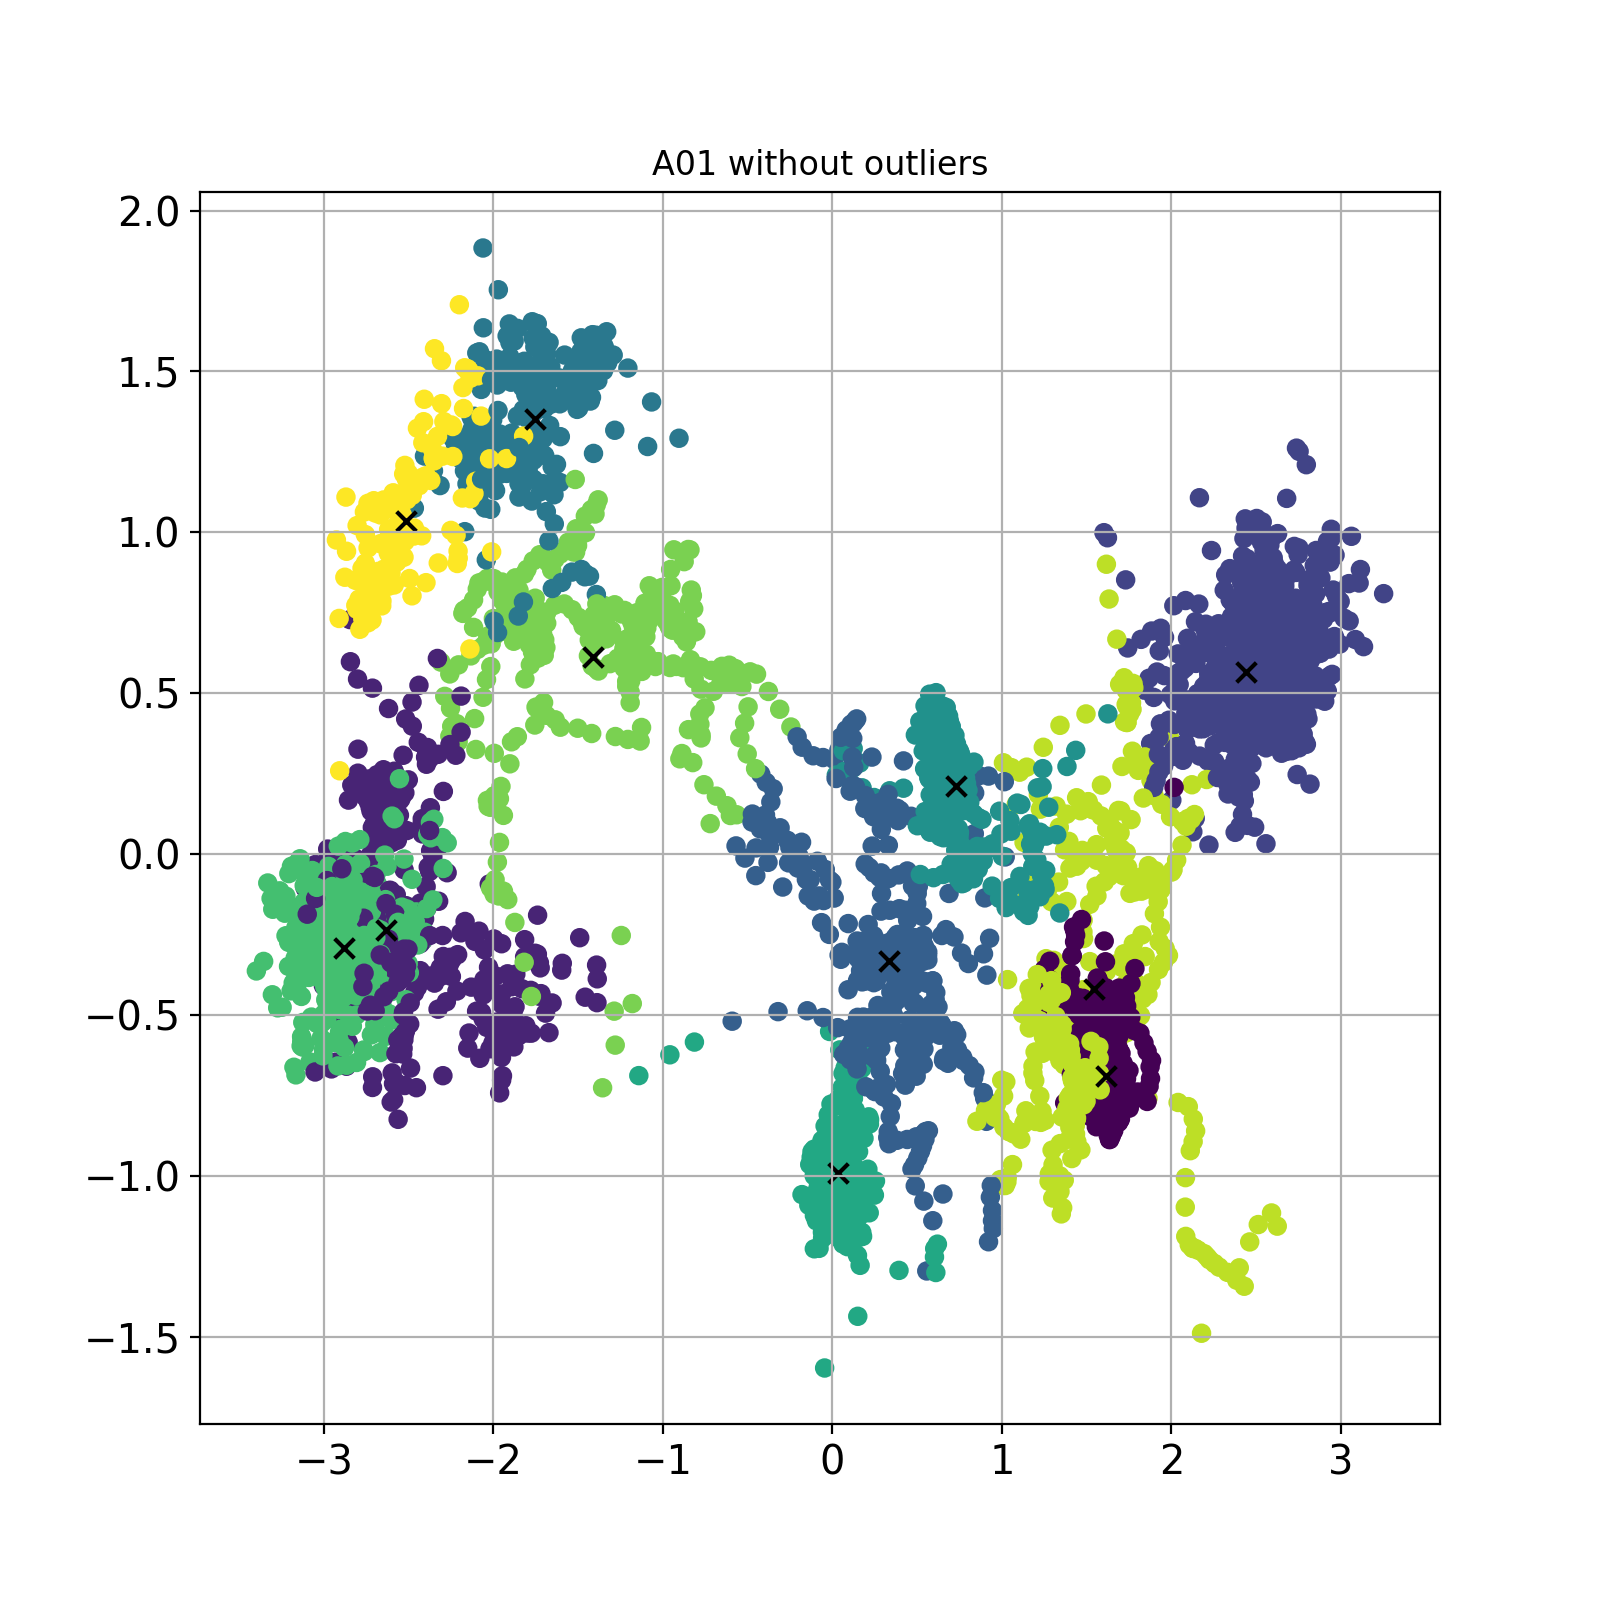

<IPython.core.display.Javascript object>


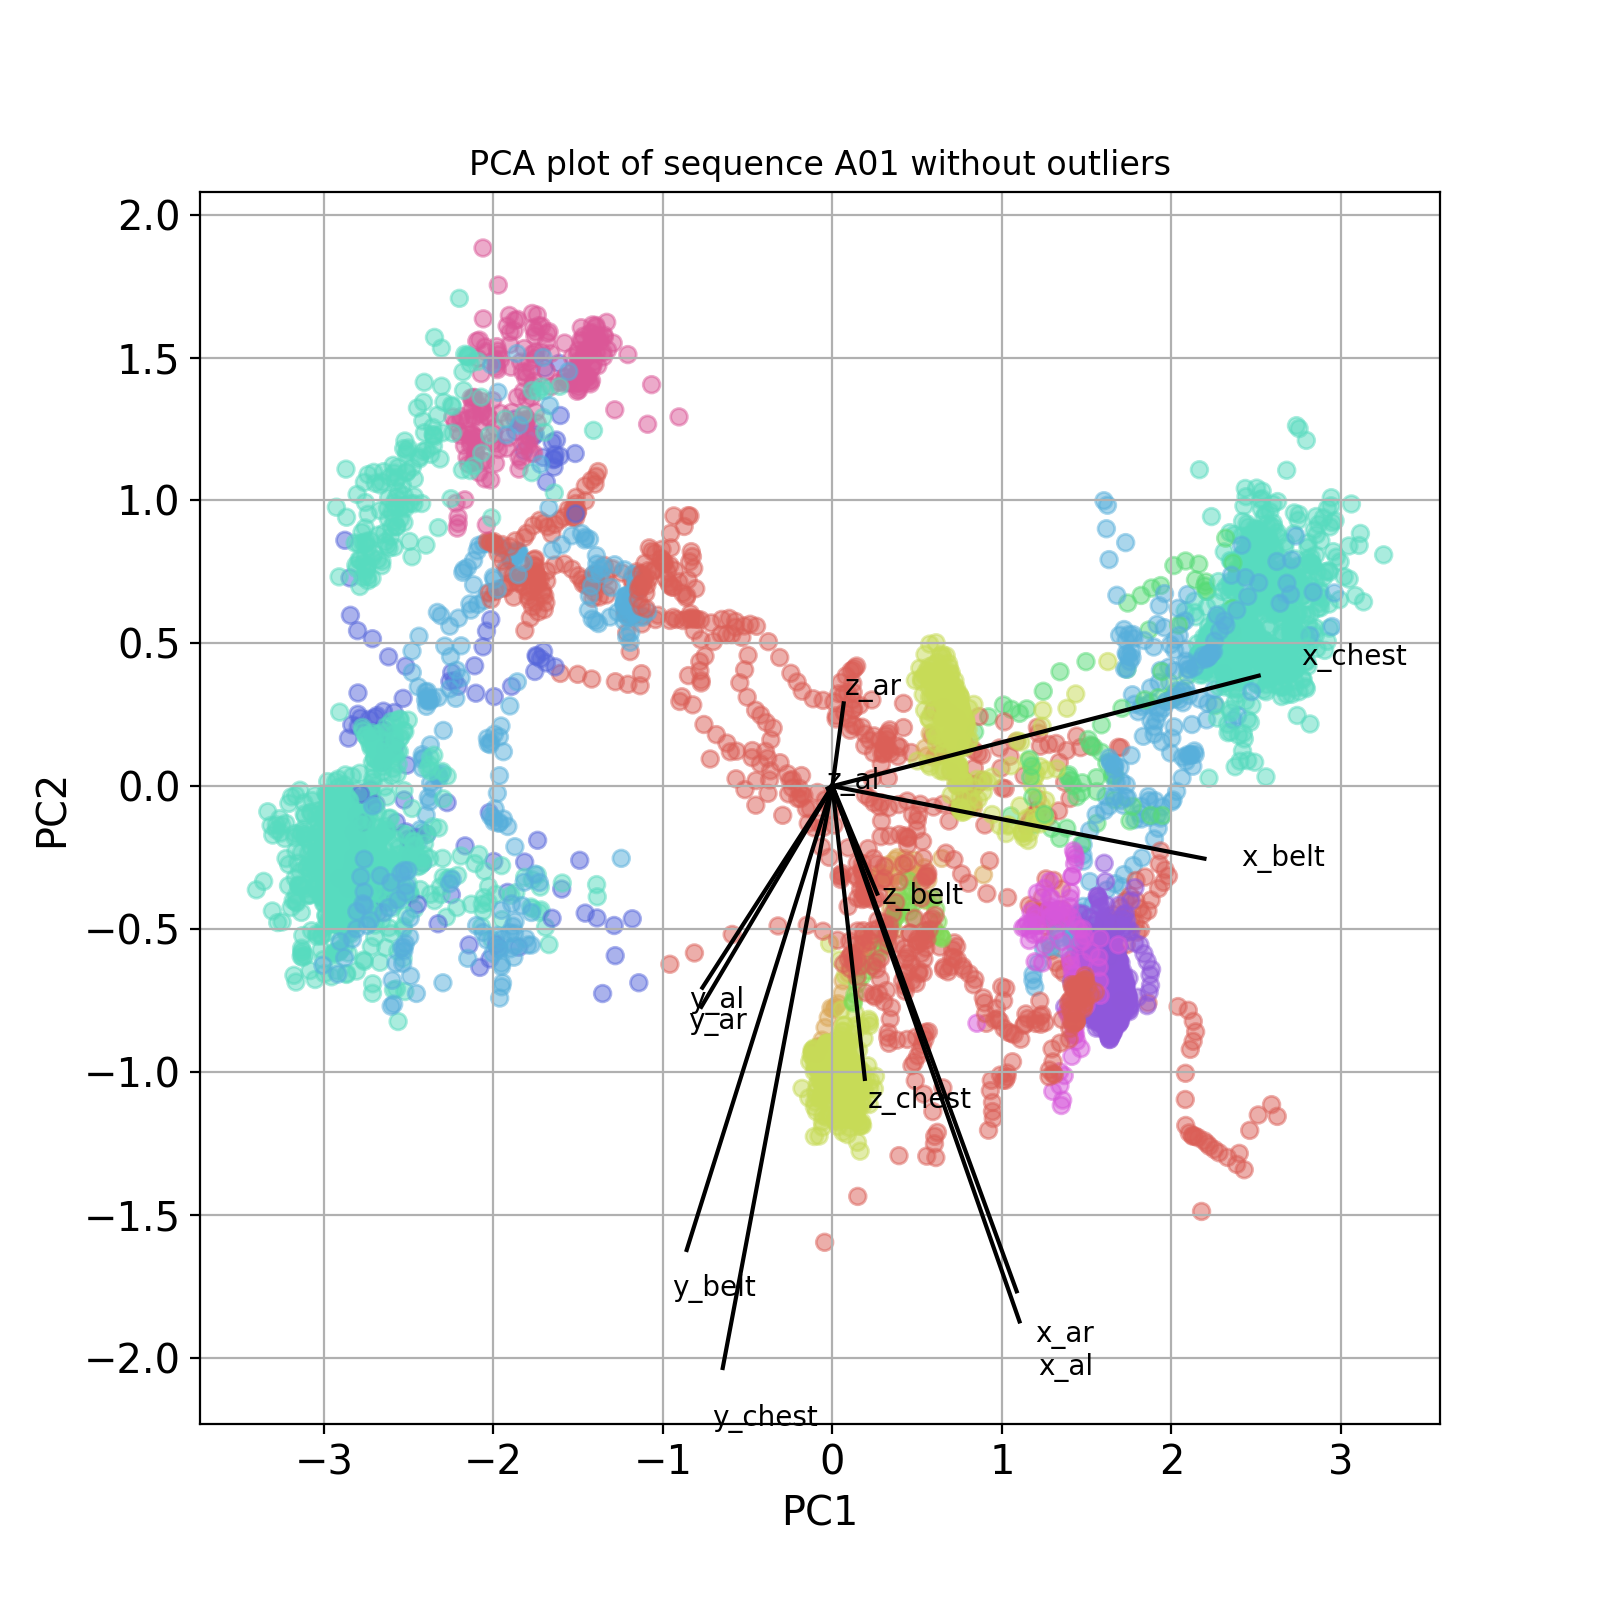

In [291]:
%matplotlib inline
import seaborn as sns

# Importing notebook makes rotating plots possible
%matplotlib notebook

# *******************************  PCA AND K-MEANS ***********************************



def plot_eigenvalues(eig_val, seq):
    # PLOTTING EIGENVALUES
    #print("Eigenvalues:\n", eig_val)
    
    # setting the design of the plot
    params = {'legend.fontsize': 'x-large','figure.figsize': (8, 4),
             'axes.labelsize': 'x-large','xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    
    plt.figure(); plt.plot(eig_val); plt.ylabel('Value'); plt.title("Eigenvalues for sequence "+seq); plt.grid()
    plt.show()

def plot_eigenvectors(eig_vec, clean_df, seq):
    # PLOTTING EIGENVECTORS CORRESPONDING TO THE 2 LARGEST EIGENVALUES
    # largest eigenvalues are eig_val[0] and eig_val[1], which corresponds to eig_vec[:,0] and eig_vec[:,1]
    
    ax = plt.figure().add_subplot(111); ax.plot(eig_vec[:,0]); ax.plot(eig_vec[:,1])
    plt.ylabel('Value'); plt.title('First two eigenvectors for sequence '+seq); plt.grid()
    
    plt.xticks(ticks = range(len(clean_df.keys())), labels=clean_df.keys(),rotation=40)
    plt.show()
    
def do_pca(clean_df, eig_vec, seq):
    # DOING PCA
    mu_vector = np.mean(clean_df, axis = 0) # the mean vector

    mu_centered_data = clean_df - mu_vector # the mean centered data

    projection = np.dot(eig_vec.T, mu_centered_data.T).T   # projecting the mean centered data

    return projection

def plot_pca(projection, clean_df, eig_vec, seq):
    # PLOTTING PCA
    # the data of the projections on the first two eigenvectors
    eigen_1_projection = projection[:,0]
    eigen_2_projection = projection[:,1]
    
    # plotting the data
    fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot(111)
    scatter = ax.scatter(eigen_1_projection,eigen_2_projection,alpha=0.5,cmap=plt.cm.brg)
    
    print(projection.shape[1])
    # plotting and scaling the lines from 0 to the point corresponding to each dimension
    for dim in range(projection.shape[1]):  # 12 dimensions
      ax.plot((0,4*eig_vec[dim,0]),(0,4*eig_vec[dim,1]), 'black')
      # labeling the vectors with corresponding coordinate (dimension)
      ax.text(4*eig_vec[dim,0]*1.1,4*eig_vec[dim,1]*1.1,clean_df.keys()[dim])

    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title("PCA plot of sequence "+seq); ax.grid(); plt.show()
    
def kmeans_pca_3d(projection, seq):
    k = 11
    kmeans = KMeans(n_clusters=k, random_state=1)
    y = kmeans.fit_predict(projection)
    
    ax = plt.figure(figsize=(8,8)).add_subplot(111, projection="3d")
    ax.scatter(projection[:, 0], projection[:, 1], projection[:, 2], projection[:, 2], c=y)
    ax.set_title(seq)
    plt.grid()
    plt.show()
    
def kmeans_pca(projection, seq):
    k = 11
    kmeans = KMeans(n_clusters=k, random_state=1)
    y = kmeans.fit_predict(projection)
    
    ax = plt.figure(figsize=(8,8)).add_subplot()
    ax.scatter(projection[:, 0], projection[:, 1], c=y)
    plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],
       s=50,c='black',marker='x')
    ax.set_title(seq)
    plt.grid()
    plt.show()

def plot_pca_with_classes_3d(projection, eig_vec, seq_df, seq):
    # the data of the projections on the first two eigenvectors?
    eig_proj_1 = projection[:,0]
    eig_proj_2 = projection[:,1]
    eig_proj_3 = projection[:,2]
    
    target = seq_df["activity"]
    
    # define a color palette based on the number of unique values in the target variable
    n_colors = len(target.unique())
    palette = sns.color_palette('hls', n_colors)

    # define a dictionary that maps each value of the target variable to a color in the palette
    color_dict = dict(zip(target.unique(), palette))

    # convert the categorical values to colors using the dictionary
    colors = target.map(color_dict)
    
    seq_df = seq_df.drop(columns=["activity"])
    
    # plotting the data
    fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot(111, projection="3d")
    scatter = ax.scatter(eig_proj_1,eig_proj_2,eig_proj_3,alpha=0.5,cmap=plt.cm.brg, c=colors)

    # plotting and scaling the lines from 0 to the point corresponding to each dimension in the 2 principal directions
    for dim in range(projection.shape[1]):  # 11 dimensions
      ax.plot((0,3*eig_vec[dim,0]),(0,3*eig_vec[dim,1]), (0,3*eig_vec[dim,2]), 'black')
      # labeling the vectors with corresponding destination (dimension)
      ax.text(3*eig_vec[dim,0]*1.1,3*eig_vec[dim,1]*1.1, 3*eig_vec[dim,2]*1.1,seq_df.keys()[dim])

    ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3'); plt.title("PCA plot of sequence "+seq); ax.grid(); plt.show()
        
    
def plot_pca_with_classes(projection, eig_vec, seq_df, seq):
    # the data of the projections on the first two eigenvectors?
    eig_proj_1 = projection[:,0]
    eig_proj_2 = projection[:,1]
    
    target = seq_df["activity"]
    
    # define a color palette based on the number of unique values in the target variable
    n_colors = len(target.unique())
    palette = sns.color_palette('hls', n_colors)

    # define a dictionary that maps each value of the target variable to a color in the palette
    color_dict = dict(zip(target.unique(), palette))

    # convert the categorical values to colors using the dictionary
    colors = target.map(color_dict)
    
    seq_df = seq_df.drop(columns=["activity"])
    
    # plotting the data
    fig = plt.figure(figsize=(8, 8)); ax = fig.add_subplot(111)
    scatter = ax.scatter(eig_proj_1,eig_proj_2,alpha=0.5,cmap=plt.cm.brg, c=colors)

    # plotting and scaling the lines from 0 to the point corresponding to each dimension in the 2 principal directions
    for dim in range(projection.shape[1]):  # 11 dimensions
      ax.plot((0,4*eig_vec[dim,0]),(0,4*eig_vec[dim,1]), 'black')
      # labeling the vectors with corresponding destination (dimension)
      ax.text(4*eig_vec[dim,0]*1.1,4*eig_vec[dim,1]*1.1,seq_df.keys()[dim])

    plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title("PCA plot of sequence "+seq); ax.grid(); plt.show()
    
    
def pca(seq, seq_df):
    # Creating a new dataframe without activity since we need to keep the orginial to plot target classes
    clean_df = seq_df.drop(columns=["activity"])

    # COVARIANCE MATRIX
    C = clean_df.cov()
    
    # getting the eigenvalues and eigenvectors from the covariance matrix
    eig_val, eig_vec = np.linalg.eig(C)
    
    #plot_eigenvalues(eig_val, seq)
    #plot_eigenvectors(eig_vec, clean_df, seq)
    projection = do_pca(clean_df, eig_vec, seq)

    plot_pca(projection, clean_df, eig_vec, seq)
    kmeans_pca(projection, seq)
    plot_pca_with_classes(projection, eig_vec, seq_df, seq)
    #kmeans_pca_3d(projection, seq)
    #plot_pca_with_classes_3d(projection, eig_vec, seq_df, seq)

    return projection

'''
projections_smooth = []

for seq, seq_df in smooth_group_dfs.items():
    projection = pca(seq + " without outliers", seq_df)
    projections_smooth.append(projection)'''
    
#projection = pca("All sequences without outliers", smooth_all_df[0])

projection_1 = pca("A01 without outliers", smooth_group_dfs["A01"])

#projection_2 = pca("A01 with outliers", seq_dfs["A01"].drop(columns=["sequence_name","outlier_score","outlier_prediction"]))

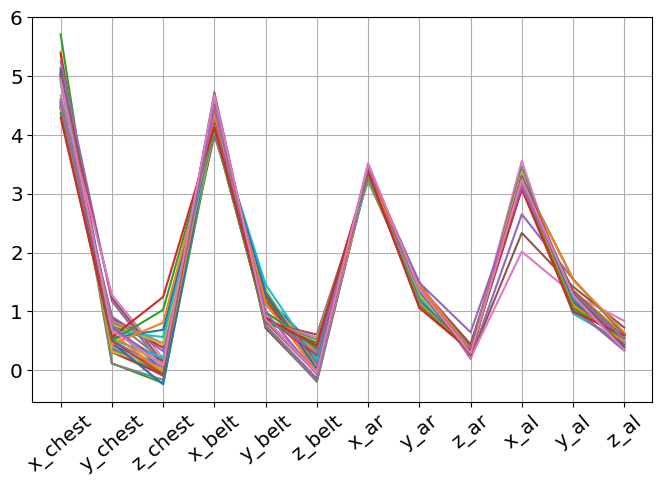

{'lying'}


In [220]:


# *******************************  ANALYZING SPECIFIC AREAS OF THE PLOTS FROM PCA AND K-MEANS  ***********************************


# ************************* FOR A01 SEQUENCE WITHOUT OUTLIERS ****************************

# Cluster in left corner - Output lying
#box_1 = np.where(((projection_1[:,0] > -3) & (projection_1[:,0] < -1.5)) & ((projection_1[:,1] > -2) & (projection_1[:,1] < 0.5)))

# Cluster - Output sitting on the ground
#box_1 = np.where(((projection_1[:,0] > -2) & (projection_1[:,0] < -1)) & ((projection_1[:,1] > 0.7) & (projection_1[:,1] < 2)))

# Middle cluster - Output sitting
#box_1 = np.where(((projection_1[:,0] > -1) & (projection_1[:,0] < 0)) & ((projection_1[:,1] > 0.5) & (projection_1[:,1] < 1)))


# ************************* FOR A01 SEQUENCE WITH OUTLIERS ****************************

# Weird spiral cluster - Output walking
#box_2 = np.where(((projection_2[:,0] > 2) & (projection_2[:,0] < 3)) & ((projection_2[:,1] > 0.5) & (projection_2[:,1] < 2)))

# Lowest right corner
box_2 = np.where(((projection_2[:,0] > 2) & (projection_2[:,0] < 4)) & ((projection_2[:,1] > -2) & (projection_2[:,1] < -1)))


# ************************* FOR ALL SEQUENCES ****************************
# Right middle (mostly purple)
#box_all = np.where(((projection[:,0] > 1) & (projection[:,0] < 2)) & ((projection[:,1] > 0.9) & (projection[:,1] < 2)))

# Left middle (green)
#box_all = np.where(((projection[:,0] > 2.5) & (projection[:,0] < 3)) & ((projection[:,1] > -0.5) & (projection[:,1] < 0)))


def plot_box(dataframe, box):
    params = {'legend.fontsize': 'x-large','figure.figsize': (8, 5),
         'axes.labelsize': 'x-large','xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    
    fig = plt.figure(); ax = fig.add_subplot()
    
    activities_in_box = set()
    # Iterating through all indexes in box
    for i in np.nditer(box):
        # Getting all unique activities in the box
        activity = dataframe.iloc[i]['activity']
        activities_in_box.add(activity)
        new_df = dataframe.drop(columns='activity')
        
        # Plotting coordinates in the box
        plt.plot(new_df.iloc[i])
        labels = new_df.keys()
        plt.xticks(ticks=range(len(new_df.keys())), labels=labels, rotation=40)

    plt.grid(); plt.show()
    print(activities_in_box)

#plot_box(smooth_all_df[0], box_all)

plot_box(seq_dfs["A01"].drop(columns=["sequence_name","outlier_score","outlier_prediction"]), box_2)